In [47]:
import warnings 

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from helpers import model_report_from

In [48]:
warnings.filterwarnings('ignore')

In [49]:
ft_train = np.load("./processed_data/features_train.npy")
ft_test = np.load("./processed_data/features_test.npy")
lbl_train = np.load("./processed_data/labels_train.npy")
lbl_test = np.load("./processed_data/labels_test.npy")

In [50]:
ft_names = np.load("./processed_data/feature_names.npy")

## Undersampling using "tomek links"

In [51]:
tl = TomekLinks(sampling_strategy='majority')
ft_train_res, lbl_train_res = tl.fit_resample(ft_train, lbl_train)

# Trying KN Classification

## Hyperparameter tuning

In [52]:
param = {
    'n_neighbors' : [5, 10, 15, 20, 30],
    'leaf_size' : [15, 30, 50, 100, 150]
}

In [53]:
clf = GridSearchCV(KNeighborsClassifier(), param, scoring='recall', refit=True, cv=5)

In [54]:
clf.fit(ft_train_res, lbl_train_res)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [15, 30, 50, 100, 150],
                         'n_neighbors': [5, 10, 15, 20, 30]},
             scoring='recall')

In [55]:
clf.best_params_

{'leaf_size': 15, 'n_neighbors': 5}

## KN Classifier

In [56]:
knc = KNeighborsClassifier(leaf_size=clf.best_params_['leaf_size'], n_neighbors=clf.best_params_['n_neighbors'])

In [57]:
knc.fit(ft_train_res, lbl_train_res)

KNeighborsClassifier(leaf_size=15)

accuracy = 0.9471624266144814
precision = 0.25
recall = 0.04
f1 = 0.06896551724137932
ROC AUC score = 0.5169135802469136


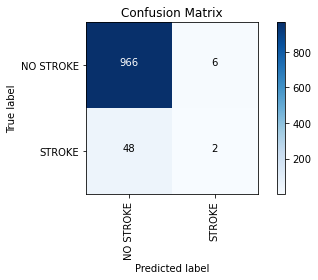

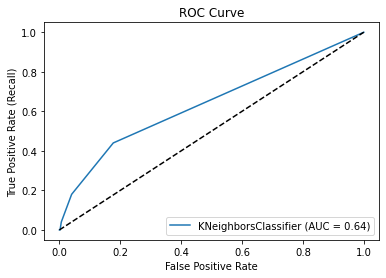

In [58]:
# report is not good... better starting basis w/ other methods, so I'll abandon this one here
model_report_from(knc, ft_test, lbl_test, [])

# SV Classification

## Hyperparameter tuning

In [59]:
param = {
    'C' : [0.1, 0.25, .5, 1, 2],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3, 6],
    'decision_function_shape' : ['ovo', 'ovr']
}

In [60]:
clf = GridSearchCV(SVC(class_weight='balanced'), param, scoring='recall', refit=True, cv=5)

In [61]:
clf.fit(ft_train, lbl_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 0.25, 0.5, 1, 2],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': [2, 3, 6],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

In [62]:
clf.best_params_

{'C': 0.1, 'decision_function_shape': 'ovo', 'degree': 2, 'kernel': 'rbf'}

## SV Classifier

In [63]:
svc = SVC(class_weight='balanced', C=0.1, decision_function_shape='ovo', kernel=clf.best_params_['kernel'])

In [64]:
svc.fit(ft_train, lbl_train)

SVC(C=0.1, class_weight='balanced', decision_function_shape='ovo')

accuracy = 0.6888454011741683
precision = 0.12146892655367232
recall = 0.86
f1 = 0.21287128712871287
ROC AUC score = 0.7700205761316872


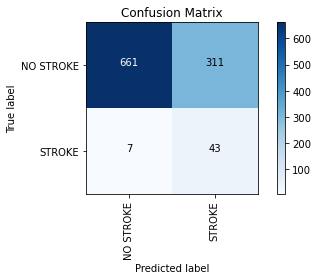

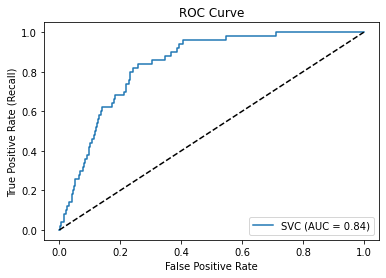

In [65]:
model_report_from(svc, ft_test, lbl_test, [])

# Bag SVC?

## Tuning Hyperparameters

In [66]:
param = {
    'n_estimators' : [10, 20, 50], 
    'max_features' : [1, 2, 3, 5, 10, 15], 
    'bootstrap_features' : [True, False]
}

In [67]:
clf = GridSearchCV(BaggingClassifier(SVC(class_weight='balanced', C=0.1, decision_function_shape='ovo', kernel='linear')), param, scoring='recall', refit=True, cv=5)

In [68]:
clf.fit(ft_train, lbl_train)
clf.best_params_

{'bootstrap_features': False, 'max_features': 10, 'n_estimators': 20}

## Bagged SVC

In [69]:
bag = BaggingClassifier(SVC(class_weight='balanced', C=0.1, decision_function_shape='ovo', kernel='rbf'), n_estimators=10, max_features=10, bootstrap_features=True)

In [70]:
bag.fit(ft_train, lbl_train)

BaggingClassifier(base_estimator=SVC(C=0.1, class_weight='balanced',
                                     decision_function_shape='ovo'),
                  bootstrap_features=True, max_features=10)

accuracy = 0.7181996086105675
precision = 0.12101910828025478
recall = 0.76
f1 = 0.2087912087912088
ROC AUC score = 0.7380246913580247


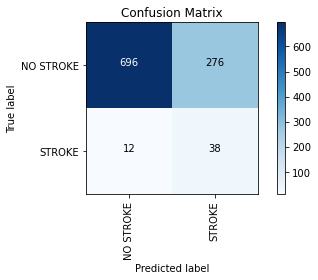

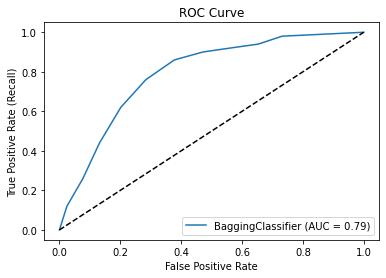

In [71]:
model_report_from(bag, ft_test, lbl_test, [])

# Random Forest is what Stripe uses?

One of the most difficult tasks at Stripe is fraud detection. These occur very infrequently so they are dealing with an unbalanced binary classification problem. In their blog they explain that they have found random forests to be best suited to these issues. Therefore, I'm going to make the best random forest model that I can...
https://stripe.com/radar/guide

## Hyperparameter tuning

In [72]:
param = {
    'n_estimators' : [50, 100, 150, 200, 300, 500],
    'max_leaf_nodes' : [16, 24, 30]
}

In [73]:
clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", n_jobs=-1, criterion='entropy'), param, scoring='recall', refit=True, cv=5)

In [74]:
clf.fit(ft_train, lbl_train)
clf.best_params_

{'max_leaf_nodes': 16, 'n_estimators': 100}

## Random Forest Model

In [75]:
rfc = RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'], max_leaf_nodes=clf.best_params_['max_leaf_nodes'], n_jobs=-1, class_weight='balanced', criterion='entropy')

In [76]:
rfc.fit(ft_train_res, lbl_train_res)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_leaf_nodes=16, n_jobs=-1)

accuracy = 0.7064579256360078
precision = 0.12797619047619047
recall = 0.86
f1 = 0.22279792746113988
ROC AUC score = 0.7792798353909465


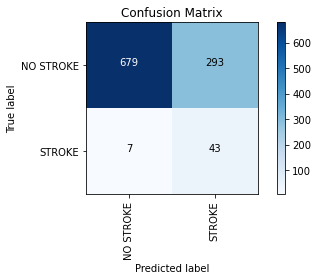

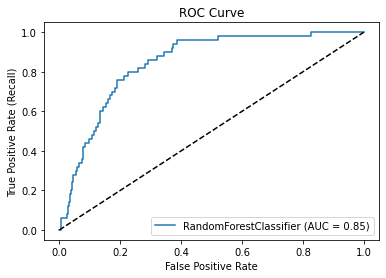

In [77]:
model_report_from(rfc, ft_test, lbl_test, [])

## Taking a peek at feature importances

In [78]:
rfc_fi = rfc.feature_importances_

In [79]:
rfc_fi

array([9.05724050e-03, 5.06471485e-03, 7.80126185e-03, 4.84852503e-03,
       3.75835077e-03, 2.46864069e-04, 7.82946537e-03, 1.36929799e-02,
       5.85147646e-02, 3.66481728e-03, 6.98576640e-03, 5.35469114e-03,
       7.75777378e-03, 0.00000000e+00, 6.02958134e-02, 4.18667726e-02,
       4.27504727e-01, 5.72874438e-02, 3.14878096e-02, 9.94337917e-02,
       8.53636786e-02, 6.21827475e-02])

In [80]:
# showing list of features that have importance greater than 1%
[(ft, rfc_fi[i], i) for i, ft in enumerate(ft_names) if rfc_fi[i] > 0.01]

[('Self-employed', 0.013692979850636739, 7),
 ('children', 0.05851476462093259, 8),
 ('No', 0.060295813436330094, 14),
 ('Yes', 0.04186677261093166, 15),
 ('age', 0.4275047272388553, 16),
 ('hypertension', 0.05728744379266725, 17),
 ('heart_disease', 0.031487809601387876, 18),
 ('avg_glucose_level', 0.09943379172210977, 19),
 ('bmi', 0.0853636785815058, 20),
 ('age_weighted_bmi_deviation', 0.06218274750601894, 21)]

# Voting Classifier :D

In [98]:
lr = LogisticRegression(class_weight='balanced', C=0.003)
mlp = MLPClassifier(activation='identity', hidden_layer_sizes=(75,50,50,25,))

In [99]:
voting = VotingClassifier(
    estimators=[('lr', lr), ('rfc', rfc), ('bag', bag), ('mlp', mlp)],
    voting='hard',
    weights=[1, 2, 0.5, 1.5]
)

In [100]:
voting.fit(ft_train_res, lbl_train_res)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.003,
                                                 class_weight='balanced')),
                             ('rfc',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_leaf_nodes=16,
                                                     n_jobs=-1)),
                             ('bag',
                              BaggingClassifier(base_estimator=SVC(C=0.1,
                                                                   class_weight='balanced',
                                                                   decision_function_shape='ovo'),
                                                bootstrap_features=True,
                                                max_features=10)),
                             ('mlp',
                        

accuracy = 0.7436399217221135
precision = 0.14429530201342283
recall = 0.86
f1 = 0.2471264367816092
ROC AUC score = 0.7988271604938271


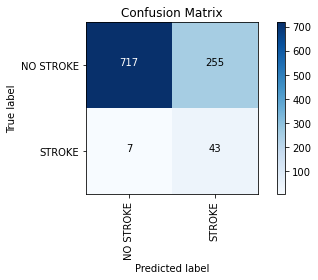

roc curve wont work because voting doesn't implement predicted prob


In [101]:
try: 
    model_report_from(voting, ft_test, lbl_test, [])
except ValueError:
    print('roc curve wont work because voting doesn\'t implement predicted prob')

# AdaBoost

## Hyperparameter tuning

In [85]:
param = {
    'base_estimator' : [DecisionTreeClassifier(class_weight='balanced', splitter='random', max_leaf_nodes=16), SVC(class_weight='balanced', C=0.1, decision_function_shape='ovo', kernel='rbf')],
    'n_estimators' : [10, 20, 50, 100, 200], 
    'algorithm' : ['SAMME', 'SAMME.R'],
    'learning_rate' : [0.1, 0.5, 1, 2]
}

In [86]:
clf = GridSearchCV(AdaBoostClassifier(), param, scoring='recall', refit=True, cv=5)

In [87]:
clf.fit(ft_train, lbl_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [DecisionTreeClassifier(class_weight='balanced',
                                                                   max_leaf_nodes=16,
                                                                   splitter='random'),
                                            SVC(C=0.1, class_weight='balanced',
                                                decision_function_shape='ovo')],
                         'learning_rate': [0.1, 0.5, 1, 2],
                         'n_estimators': [10, 20, 50, 100, 200]},
             scoring='recall')

In [88]:
clf.best_params_

{'algorithm': 'SAMME',
 'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=16,
                        splitter='random'),
 'learning_rate': 0.1,
 'n_estimators': 20}

## AdaBoost Classifier

In [92]:
ada = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=16, splitter='random'), learning_rate=0.1, n_estimators=20, algorithm='SAMME')

In [93]:
ada.fit(ft_train, lbl_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_leaf_nodes=16,
                                                         splitter='random'),
                   learning_rate=0.1, n_estimators=20)

accuracy = 0.7514677103718199
precision = 0.1482758620689655
recall = 0.86
f1 = 0.2529411764705882
ROC AUC score = 0.8029423868312756


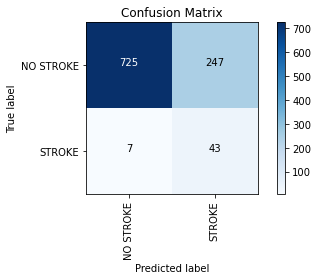

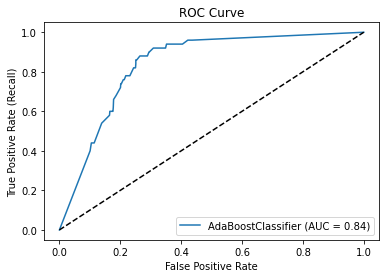

In [94]:
model_report_from(ada, ft_test, lbl_test, [])